# GAN in Pytorch Implementation

### 1. Import necessary modules and library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### 2. Define the Generator and Discriminator

The generator takes a noise vector as input and outputs an image.

In [2]:
# Define the Generator 

class Generator(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim,128),
            nn.ReLU(True),
            nn.Linear(128,256),
            nn.ReLU(True),
            nn.Linear(256,output_dim),
            nn.Tanh()
        )
    def forward(self,x):
        return self.model(x)

In [3]:
# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self,input_dim):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim,256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(256,128),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(128,1),
            nn.Sigmoid()
        )

    def forward(self,x):
        return self.model(x)

### 3. Hyperparameters definition and data preparation
Hyperparameters definition and data preparation

In [4]:
# Hyperparameters
latent_dim = 100
img_size = 14*14
batch_size = 64
learning_rate = 2e-4
num_epochs = 20

# Prepare the dataset with image resizing to 14x14
transform = transforms.Compose([
    transforms.Resize(14),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### 4. Initialize Models, Loss Function, and Optimizers

In [7]:
generator = Generator(input_dim=latent_dim,output_dim=img_size)#.to("cuda")
discriminator = Discriminator(input_dim=img_size)#.to("cuda")

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(),lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(),lr=learning_rate)

### 5.Training the model

In [8]:
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        
        # Adversarial ground truths
        valid = torch.ones((imgs.size(0), 1), requires_grad=False)#.to('cuda')
        fake = torch.zeros((imgs.size(0), 1), requires_grad=False)#.to('cuda')
        
        # Configure input
        real_imgs = imgs.view(imgs.size(0), -1)#.to('cuda')
        
        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn((imgs.size(0), latent_dim))#.to('cuda')
        gen_imgs = generator(z)
        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()
        
        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Print progress
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(train_loader)} \
                  Loss D: {d_loss.item()}, loss G: {g_loss.item()}")

Epoch [0/20] Batch 0/938                   Loss D: 0.6594363451004028, loss G: 0.7181161642074585
Epoch [0/20] Batch 100/938                   Loss D: 0.4452469050884247, loss G: 0.8942567110061646
Epoch [0/20] Batch 200/938                   Loss D: 0.1903025507926941, loss G: 1.6183490753173828
Epoch [0/20] Batch 300/938                   Loss D: 0.06303326040506363, loss G: 2.577511787414551
Epoch [0/20] Batch 400/938                   Loss D: 0.015050701797008514, loss G: 3.747377872467041
Epoch [0/20] Batch 500/938                   Loss D: 0.04809682071208954, loss G: 3.058893918991089
Epoch [0/20] Batch 600/938                   Loss D: 0.04630289971828461, loss G: 3.064607620239258
Epoch [0/20] Batch 700/938                   Loss D: 0.27788734436035156, loss G: 1.5983260869979858
Epoch [0/20] Batch 800/938                   Loss D: 0.09166186302900314, loss G: 2.810089349746704
Epoch [0/20] Batch 900/938                   Loss D: 0.0581805557012558, loss G: 2.683511734008789
E

### 6.visualization

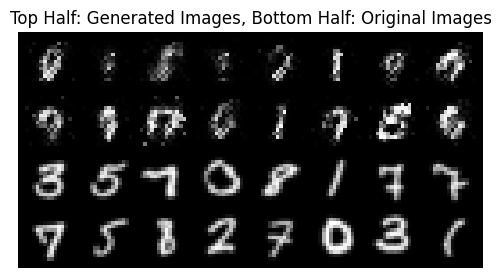

In [9]:
# Visualizing Generated and Original Images
def show_images(gen_images, real_images):
    gen_images = gen_images.view(gen_images.size(0), 1, 14, 14).cpu().data
    real_images = real_images.view(real_images.size(0), 1, 14, 14).cpu().data
    
    # Concatenate generated and real images
    images = torch.cat([gen_images, real_images])
    
    grid = torchvision.utils.make_grid(images, nrow=8, normalize=True)
    
    # Set smaller figure size
    plt.figure(figsize=(6, 6))  # Smaller figure
    plt.imshow(grid.permute(1, 2, 0))
    plt.title('Top Half: Generated Images, Bottom Half: Original Images')
    plt.axis('off')
    plt.show()

# Generate images
z = torch.randn(16, latent_dim)#.to('cuda')  # Reduced to 16 for a smaller plot
gen_imgs = generator(z)

# Get a batch of real images
real_imgs, _ = next(iter(train_loader))
real_imgs = real_imgs[:16].view(16, -1)#.to('cuda')  # Reduced to 16 for a smaller plot

# Show generated vs original images
show_images(gen_imgs, real_imgs)